In [1]:
!ls

bucket_size_results_algorithm_1_mh_20000000.tsv   bucket_sort_1.cpp
bucket_size_results_algorithm_1_mh_50000000.tsv   bucket_sort_2
bucket_size_results_algorithm_1_pk_20000000.tsv   bucket_sort_2.cpp
bucket_size_results_algorithm_1_pk_200000000.tsv  compile-vnode.sh
bucket_size_results_algorithm_1_pk_50000000.tsv   compile.sh
bucket_size_results_algorithm_2_mh_20000000.tsv   find_buckets.sh
bucket_size_results_algorithm_2_mh_50000000.tsv   notebook.ipynb
bucket_size_results_algorithm_2_pk_20000000.tsv   par_results_laptop.tsv
bucket_size_results_algorithm_2_pk_50000000.tsv   random_seq
bucket_sort_1					  seq_results_laptop.tsv


In [7]:
!pip3 install pandas

     |████████████████████████████████| 9.7 MB 1.6 MB/s eta 0:00:01


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [24]:

def convert_time(exec_time):
    #minutes = float(exec_time.split("m")[0])
    seconds = float(exec_time.split("s")[0])
    return seconds


In [22]:
def parse_data(filename):
    df1 = pd.read_csv(filename, sep="\t")

    df1["time_a"] = df1["time_a"].apply(convert_time)
    df1["time_b"] = df1["time_b"].apply(convert_time)
    df1["time_c"] = df1["time_c"].apply(convert_time)
    df1["time_d"] = df1["time_d"].apply(convert_time)
    df1["time_e"] = df1["time_e"].apply(convert_time)


    df1 = df1.groupby(['bucket_range'], as_index=False)
    df1 = df1.agg({'time_a':['mean','std'], 'time_b':['mean','std'],'time_c':['mean','std'],'time_d':['mean','std'],'time_e':['mean','std']})

    return df1

In [9]:
df1 = parse_data("bucket_size_results_algorithm_1_pk_50000000.tsv")
df2 = parse_data("bucket_size_results_algorithm_2_pk_50000000.tsv")

df1

bucket_range    time_a              time_b              time_c            \
                     mean       std      mean       std      mean       std   
0            64  0.222859  0.017436  7.221821  0.184561  0.838319  0.002289   
1           128  0.222871  0.018761  7.762835  1.066822  1.053591  0.049944   
2           256  0.226742  0.010348  6.828732  1.619238  1.207779  0.035967   
3           512  0.230228  0.012342  4.076589  0.578214  1.357152  0.053276   
4          1024  0.249154  0.036195  2.339141  0.112579  1.650634  0.371689   
5          2048  0.235165  0.007688  1.621303  0.081938  1.669386  0.022666   
6          4096  0.224145  0.014696  1.152127  0.121628  1.782421  0.077920   
7          8196  0.241962  0.030534  1.017808  0.124637  1.990281  0.090642   
8         20480  0.233052  0.018383  0.650179  0.039326  2.148656  0.098208   
9         40960  0.233166  0.018749  0.474841  0.015757  2.390799  0.147635   
10        81960  0.235586  0.022572  0.465273  0.047013  2.435097  0.134539   
11       204800  0.233373  0.019281  0.442144  0.019092  2.645969  0.079413   
12       409600  0.266233  0.044153  0.450199  0.038850  2.792235  0.040476   
13       819600  0.225908  0.011979  0.425616  0.019684  3.027172  0.203354   
14      1639200  0.276888  0.022649  0.469916  0.040700  3.455705  0.267965   
15      3278400  0.260977  0.021396  0.448277  0.045502  3.621857  0.261554   
16      6556800  0.304195  0.059650  0.503462  0.065634  3.876769  0.167236   

      time_d              time_e            
        mean       std      mean       std  
0   0.084655  0.009887  8.367654  0.185512  
1   0.066241  0.006573  9.105538  1.122703  
2   0.066366  0.012780  8.329619  1.646065  
3   0.059150  0.008778  5.723119  0.617104  
4   0.060483  0.015513  4.299412  0.352875  
5   0.055731  0.012110  3.581585  0.081219  
6   0.055780  0.022322  3.214474  0.158111  
7   0.044400  0.008627  3.294450  0.172152  
8   0.055320  0.008403  3.087207  0.157569  
9   0.052735  0.011988  3.151542  0.149450  
10  0.050854  0.010616  3.186811  0.163867  
11  0.041657  0.005851  3.363141  0.088328  
12  0.045810  0.010092  3.554477  0.042643  
13  0.035100  0.004151  3.713797  0.191863  
14  0.039343  0.003017  4.241852  0.302015  
15  0.041615  0.007718  4.372726  0.234483  
16  0.046227  0.016011  4.730653  0.227293

In [10]:
df2

bucket_range    time_a               time_b              time_c            \
                     mean       std       mean       std      mean       std   
0            64  0.244794  0.028439  12.908054  0.527855  0.902384  0.026775   
1           128  0.247759  0.031102  10.411760  0.388914  1.053053  0.023301   
2           256  0.244367  0.029939   7.342762  0.533893  1.184803  0.017216   
3           512  0.234661  0.008851   4.888667  0.146944  1.347010  0.051924   
4          1024  0.227870  0.009237   3.379979  0.243191  1.470081  0.029134   
5          2048  0.222068  0.004537   2.076613  0.094170  1.587365  0.019250   
6          4096  0.218943  0.003572   1.716601  0.039933  1.703852  0.019468   
7          8196  0.218220  0.004375   1.386116  0.040220  1.859128  0.025138   
8         20480  0.221911  0.004546   1.064526  0.017332  2.031026  0.014739   
9         40960  0.223158  0.012015   0.845873  0.013830  2.165190  0.032013   
10        81960  0.222623  0.013610   0.787085  0.010293  2.291410  0.034264   
11       204800  0.217220  0.002420   0.776137  0.007452  2.464512  0.019519   
12       409600  0.228981  0.010416   0.787592  0.028951  2.617456  0.018749   
13       819600  0.224677  0.009620   0.801661  0.050273  2.753767  0.058173   
14      1639200  0.275687  0.032441   1.020054  0.157206  3.693201  0.172522   
15      3278400  0.290412  0.027144   1.119788  0.207428  3.726699  0.177310   
16      6556800  0.228919  0.011103   0.895853  0.180637  3.247555  0.068987   

      time_d               time_e            
        mean       std       mean       std  
0   0.042360  0.002952  14.097593  0.559374  
1   0.044765  0.002357  11.757338  0.372008  
2   0.039709  0.004045   8.811642  0.536675  
3   0.038482  0.003146   6.508820  0.160607  
4   0.037836  0.002647   5.115766  0.271057  
5   0.037191  0.004838   3.923237  0.093544  
6   0.033435  0.002998   3.672830  0.041090  
7   0.033750  0.003656   3.497214  0.034478  
8   0.035763  0.006515   3.353226  0.012527  
9   0.032978  0.003255   3.267200  0.035307  
10  0.031655  0.002704   3.332773  0.031557  
11  0.033473  0.003434   3.491341  0.014605  
12  0.031710  0.003307   3.665738  0.051540  
13  0.030798  0.002473   3.810903  0.074941  
14  0.053556  0.018552   5.042499  0.304742  
15  0.047261  0.007807   5.184159  0.337882  
16  0.032709  0.003130   4.405037  0.185119

In [11]:
def plot_bucket_times(df):
    fig = plt.figure(figsize=(12, 7), dpi=80)
    plt.title("Time of execution by bucket size")
    plt.xlabel("Bucker size")
    plt.ylabel("Time [s]")

    ax = fig.add_subplot(1, 1, 1)

    ax.set_xscale('log')
    ax.set_yscale('linear')
    plt.xlim([32, 6556800*2])

    plt.errorbar(df['bucket_range'], df['time_e']["mean"], df['time_e']["std"], linestyle='None', zorder=3, elinewidth=1, capsize=2)
    
    plt.scatter(df['bucket_range'], df['time_e']['mean'])

<ipython-input-11-cbcaa3a847d4>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


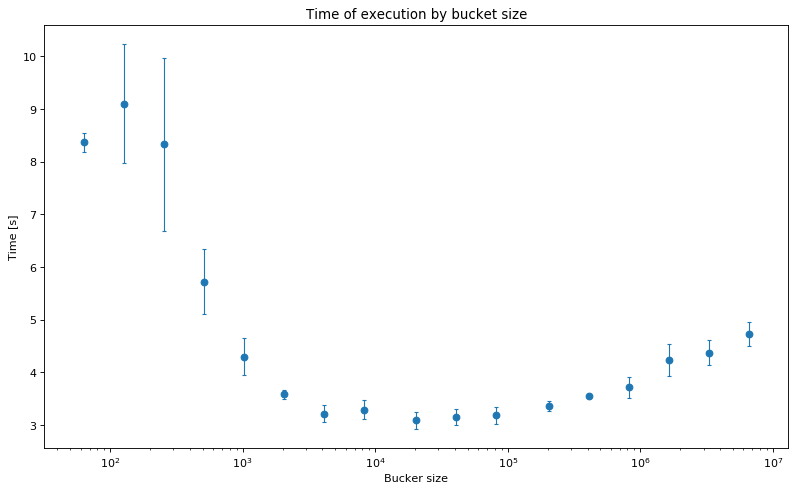

In [12]:
plot_bucket_times(df1)

<ipython-input-11-cbcaa3a847d4>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


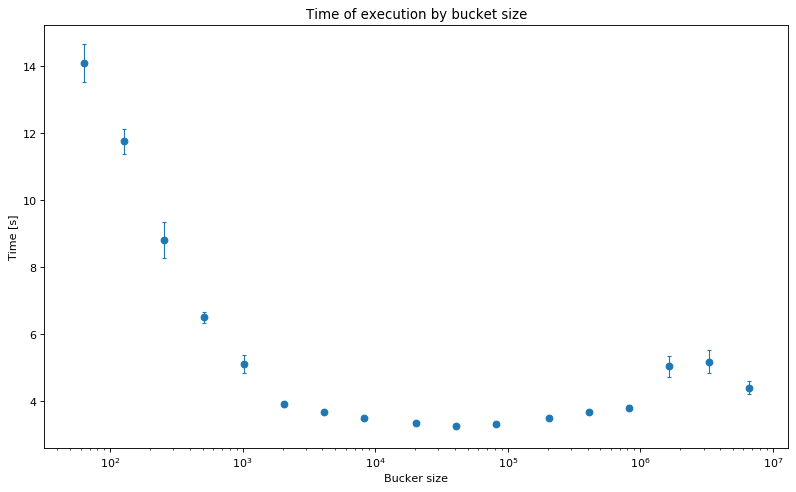

In [13]:
plot_bucket_times(df2)

In [71]:
def plot_bucket_times_bc(df):
    fig = plt.figure(figsize=(12, 7), dpi=80)
    plt.title("Time of execution by bucket size")
    plt.xlabel("Bucker size")
    plt.ylabel("Time [s]")

    ax = fig.add_subplot(1, 1, 1)

    ax.set_xscale('log')
    ax.set_yscale('linear')
    plt.xlim([32, 6556800])

    plt.plot(df['bucket_range'], df['time_b']['mean'], "--o", label="bucket insertion time") 
    plt.errorbar(df['bucket_range'], df['time_b']["mean"], df['time_b']["std"], linestyle='None', zorder=3, elinewidth=1, capsize=2)
    plt.plot(df['bucket_range'], df['time_c']['mean'], "--o", label="bucket sorting time")
    plt.errorbar(df['bucket_range'], df['time_c']["mean"], df['time_c']["std"], linestyle='None', zorder=3, elinewidth=1, capsize=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

<ipython-input-71-b06adf448e9a>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: Futur

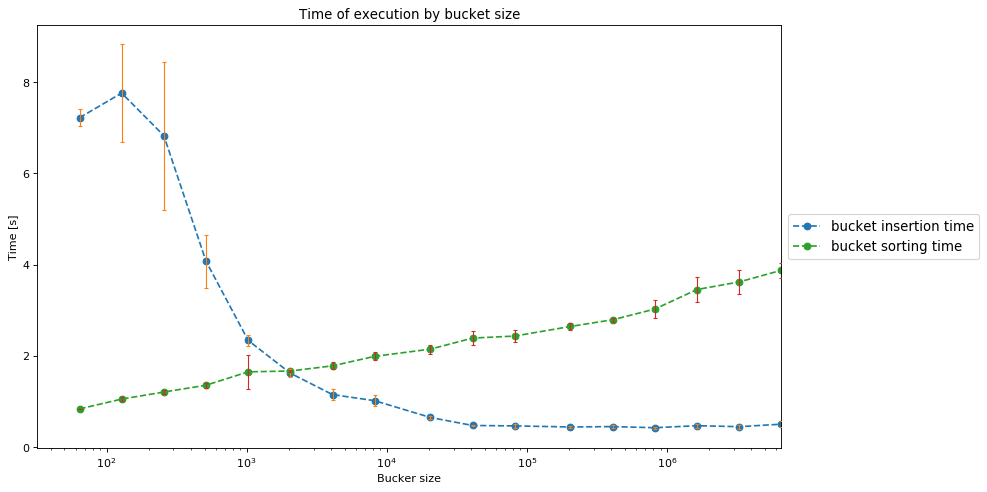

In [72]:
plot_bucket_times_bc(df1)

<ipython-input-71-b06adf448e9a>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


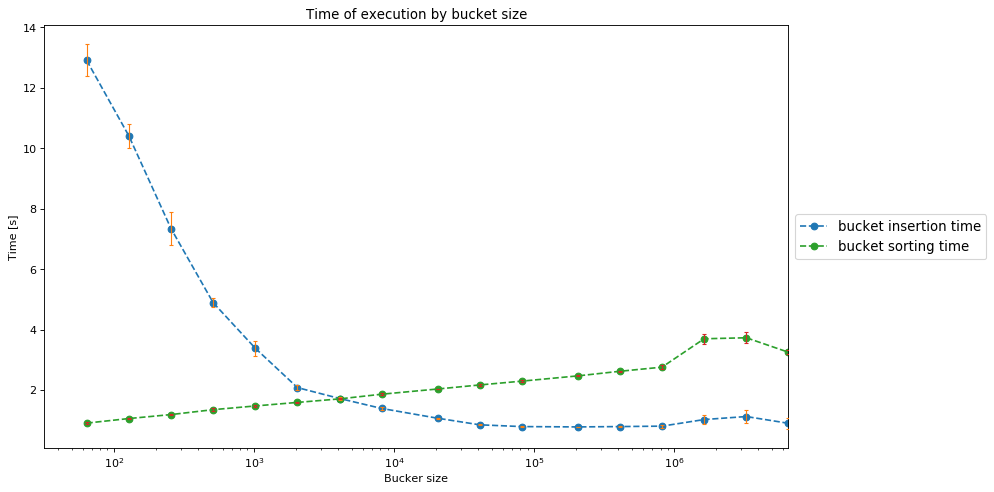

In [73]:
plot_bucket_times_bc(df2)

In [86]:
def parse_speedup_data(filename,*,speedup_type):
    df1 = pd.read_csv(filename, sep="\t")

    df1["time_a"] = df1["time_a"].apply(convert_time)
    df1["time_b"] = df1["time_b"].apply(convert_time)
    df1["time_c"] = df1["time_c"].apply(convert_time)
    df1["time_d"] = df1["time_d"].apply(convert_time)
    df1["time_e"] = df1["time_e"].apply(convert_time)

    if(speedup_type == "strong"):
        df1["a_speedup"] = df1["time_a"][0] / df1["time_a"]
        df1["b_speedup"] = df1["time_b"][0] / df1["time_b"]
        df1["c_speedup"] = df1["time_c"][0] / df1["time_c"]
        df1["d_speedup"] = df1["time_d"][0] / df1["time_d"]
        df1["e_speedup"] = df1["time_e"][0] / df1["time_e"]
    if(speedup_type == "weak"):
        df1["a_speedup"] = df1["time_a"][0]*df1["threads"] / df1["time_a"]
        df1["b_speedup"] = df1["time_b"][0]*df1["threads"] / df1["time_b"]
        df1["c_speedup"] = df1["time_c"][0]*df1["threads"] / df1["time_c"]
        df1["d_speedup"] = df1["time_d"][0]*df1["threads"] / df1["time_d"]
        df1["e_speedup"] = df1["time_e"][0]*df1["threads"] / df1["time_e"]


    df1 = df1.groupby(['threads'], as_index=False)
    df1 = df1.agg({'time_a':['mean','std'], 'time_b':['mean','std'],'time_c':['mean','std'],'time_d':['mean','std'],'time_e':['mean','std'], "a_speedup":['mean','std'], "b_speedup":['mean','std'], "c_speedup":['mean','std'], "d_speedup":['mean','std'], "e_speedup":['mean','std']})

    return df1


- best for algorithm1 - 20480
- best for algorithm2 - 40960

In [93]:
df_s1 = parse_speedup_data('speedups_strong_50000000.20480_1_no_reserve.tsv', speedup_type="strong");
df_s2 = parse_speedup_data('speedups_strong_50000000.40960_2_no_reserve.tsv', speedup_type="strong");

In [94]:
df_s1['time_a']

,mean,std
0,0.257995,0.042925
1,0.166611,0.007648
2,0.139275,0.014527
3,0.116029,0.032933
4,0.128878,0.007247
5,0.098128,0.013804
6,0.107079,0.031966
7,0.105142,0.018310


In [95]:
df_s2

threads    time_a              time_b              time_c            \
               mean       std      mean       std      mean       std   
0       1  0.274709  0.033979  1.034383  0.091172  2.283534  0.031387   
1       2  0.138411  0.009213  1.249053  0.030788  1.199119  0.038811   
2       3  0.105183  0.020120  1.334748  0.040139  0.889220  0.045141   
3       4  0.106255  0.037628  1.438998  0.048093  0.768424  0.087984   
4       5  0.110251  0.017606  1.305290  0.090584  0.864779  0.129976   
5       6  0.115733  0.027572  1.391530  0.191144  0.786723  0.066567   
6       7  0.102600  0.012014  1.310069  0.088848  0.814614  0.089556   
7       8  0.102301  0.009202  1.373987  0.096504  0.792790  0.059284   

     time_d              time_e  ... a_speedup           b_speedup            \
       mean       std      mean  ...      mean       std      mean       std   
0  0.040427  0.017880  3.633053  ...  0.906294  0.108144  0.998152  0.082959   
1  0.032108  0.004271  2.618691  ...  1.783888  0.118439  0.822181  0.020824   
2  0.030780  0.004979  2.359932  ...  2.395143  0.366275  0.769563  0.022975   
3  0.030885  0.003272  2.344562  ...  2.510370  0.699187  0.713952  0.024435   
4  0.032277  0.003716  2.312596  ...  2.273589  0.330769  0.789367  0.054163   
5  0.031555  0.004927  2.325541  ...  2.221020  0.503121  0.747751  0.092372   
6  0.034848  0.005753  2.262132  ...  2.425224  0.290868  0.786238  0.050590   
7  0.028218  0.001798  2.297296  ...  2.421611  0.231375  0.749995  0.052495   

  c_speedup           d_speedup           e_speedup            
       mean       std      mean       std      mean       std  
0  1.004535  0.013745  0.824547  0.241097  0.990177  0.021770  
1  1.914262  0.060647  0.944486  0.116421  1.373570  0.025566  
2  2.584377  0.125685  0.989463  0.132030  1.524839  0.045014  
3  3.012223  0.300143  0.977410  0.098569  1.536590  0.073851  
4  2.698381  0.385034  0.938328  0.120288  1.563126  0.123286  
5  2.932642  0.256532  0.965156  0.133830  1.552368  0.106786  
6  2.844184  0.326724  0.876270  0.132384  1.590048  0.029227  
7  2.905702  0.212471  1.063871  0.062648  1.568714  0.079527  

[8 rows x 21 columns]

In [96]:
def plot_speedup(df, name, label):
    plt.scatter(df['threads'], df[name]['mean'], label=label) 
    plt.errorbar(df['threads'], df[name]["mean"], df[name]["std"], linestyle='None', zorder=3, elinewidth=1, capsize=2)

def plot_speedups(df, plot_theoretical=False):
    fig = plt.figure(figsize=(12, 7), dpi=80)
    plt.title("Relative speedups")
    plt.xlabel("Number of threads")
    plt.ylabel("Relative_speedup")

    ax = fig.add_subplot(1, 1, 1)

    ax.set_xscale('linear')
    ax.set_yscale('linear')

    plot_speedup(df, 'a_speedup', 'a_speedup')
    plot_speedup(df, 'b_speedup', 'b_speedup')
    plot_speedup(df, 'c_speedup', 'c_speedup')
    plot_speedup(df, 'd_speedup', 'd_speedup')
    plot_speedup(df, 'e_speedup', 'e_speedup')
    
    if(plot_theoretical):
        plt.plot(df['threads'], df['threads'], "--", label="theoretical ideal speedup")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

<ipython-input-96-e7f9ed1df680>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: Futu

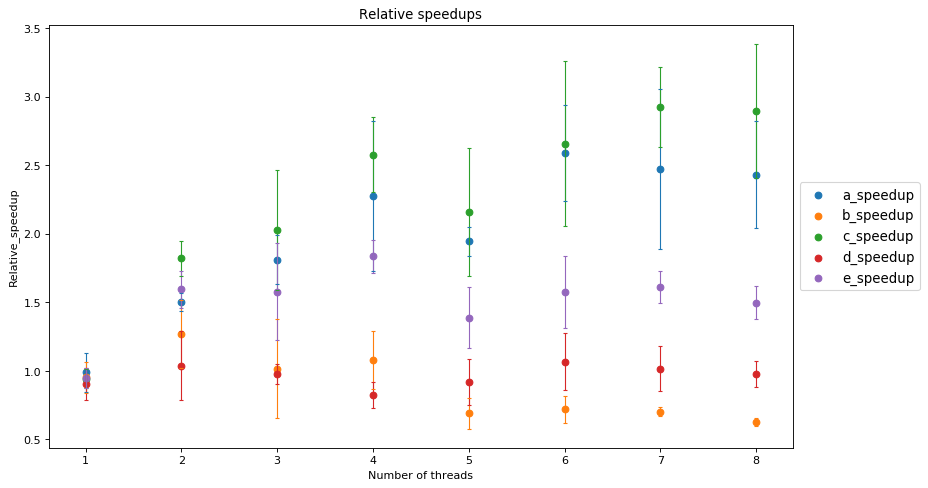

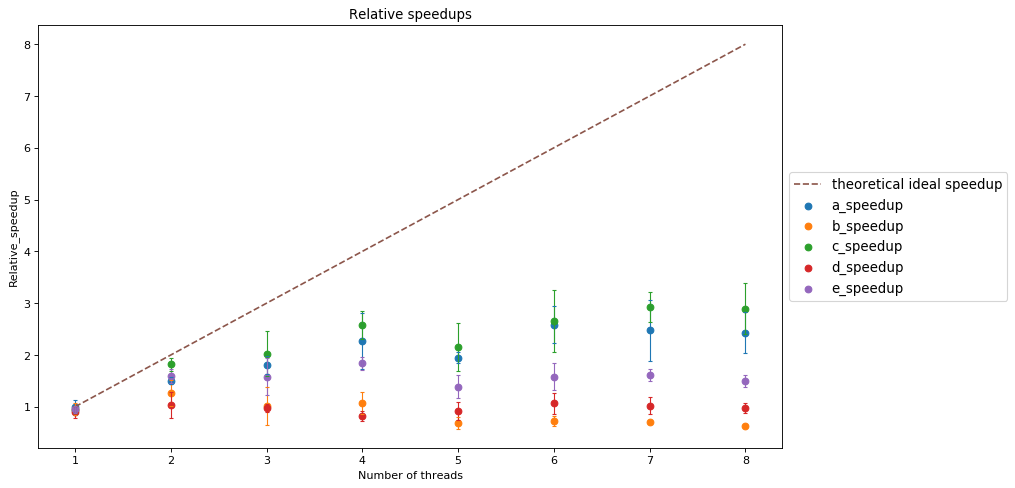

In [97]:
plot_speedups(df_s1)
plot_speedups(df_s1, True)

<ipython-input-96-e7f9ed1df680>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


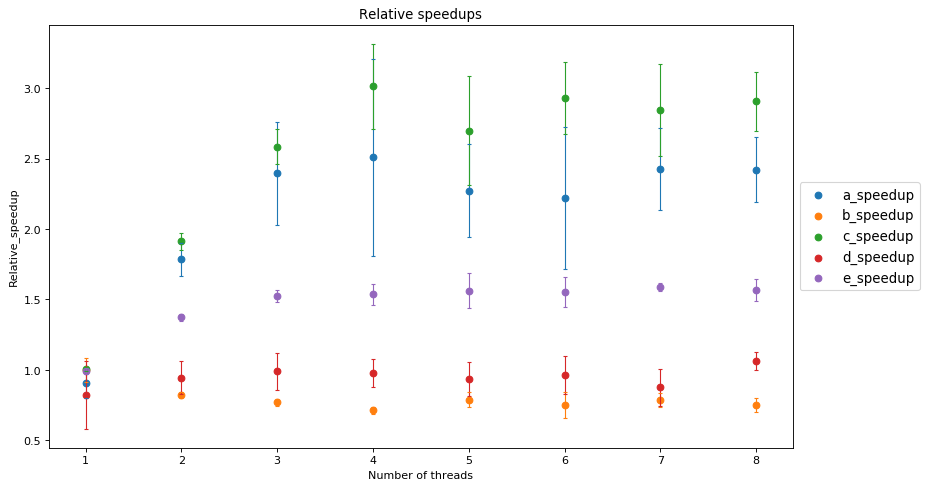

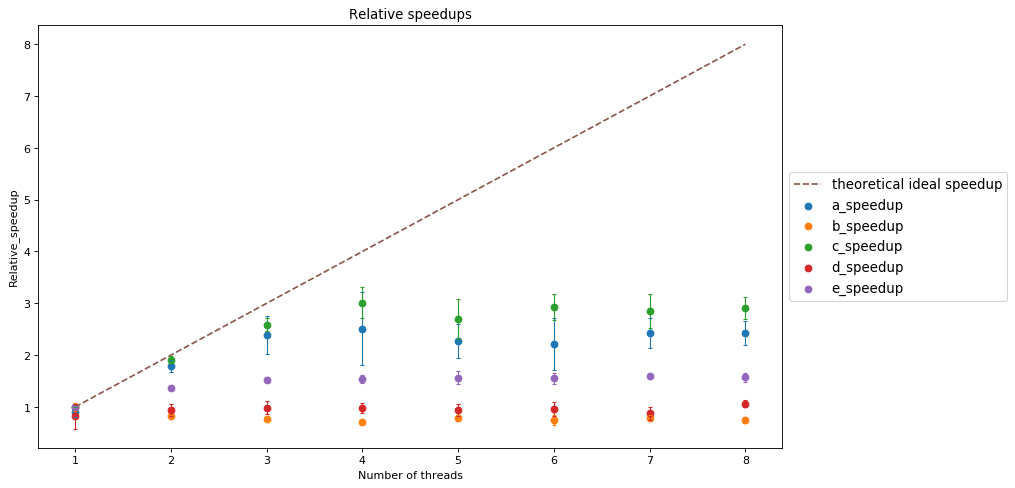

In [98]:
plot_speedups(df_s2)
plot_speedups(df_s2, True)

In [99]:
df_s1 = parse_speedup_data('speedups_weak_50000000.20480_1.tsv', speedup_type="weak");
df_s2 = parse_speedup_data('speedups_weak_50000000.40960_2-sec.tsv', speedup_type="weak");

<ipython-input-83-29bb16e65f5b>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


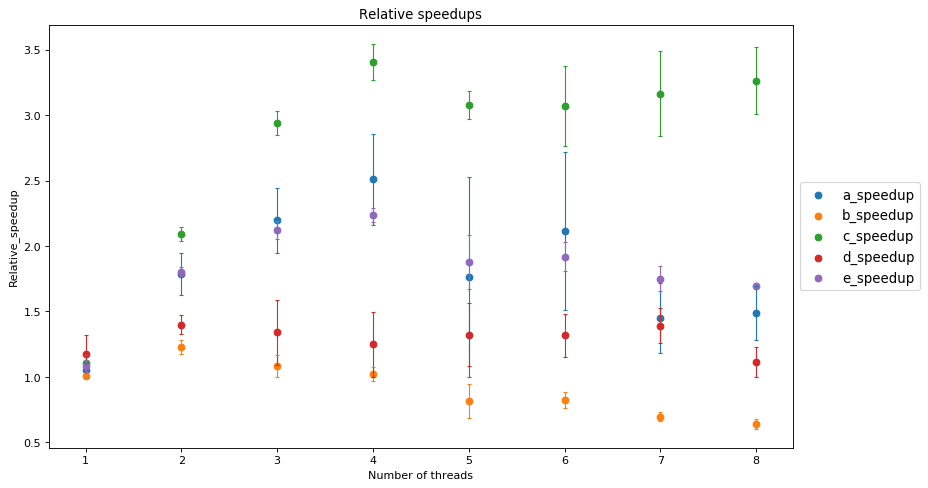

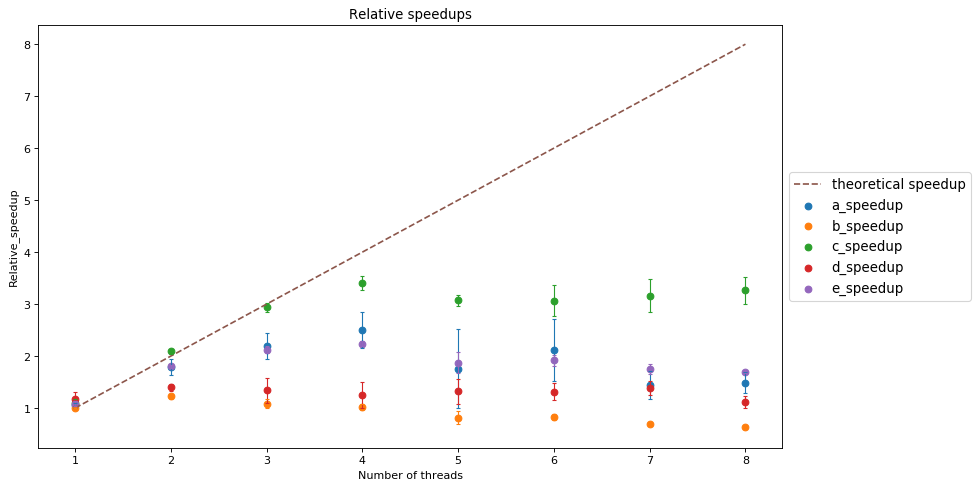

In [91]:
plot_speedups(df_s1)
plot_speedups(df_s1, True)

<ipython-input-83-29bb16e65f5b>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


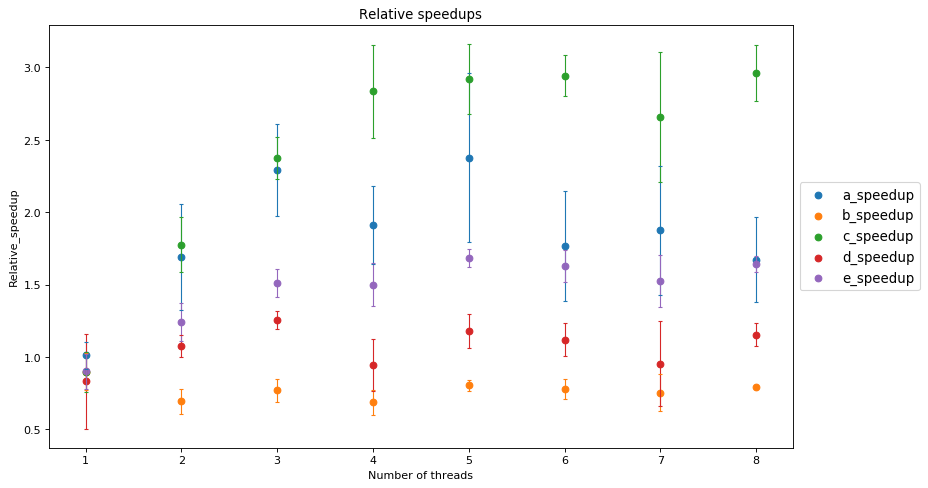

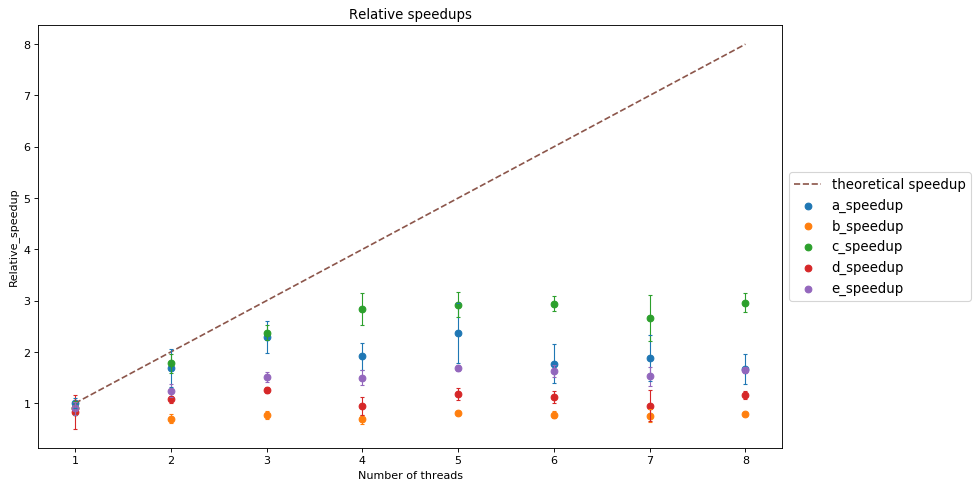

In [92]:
plot_speedups(df_s2)
plot_speedups(df_s2, True)